In [1]:
import warnings
import numpy as np
import os
np.warnings = warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
import carculator
from carculator import *
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
carculator.__version__

(1, 8, 5)

# Importance!
You need to install conda and create a virtual environment so that specific packages can be installed without your main python library. 

For carculator to work, you need:
* Numpy <1.24
* Carculator_utils = 1.1.1

You can install numpy using python -m pip install numpy==1.23.5

Same for Carculator_utils although it is usually installed together with Carculator

In [4]:
np.__version__

'1.23.5'

# Set working directory

In [5]:
# Set the working directory
# Replace 'your_directory_path' with the folder where your data is stored
os.chdir('C:/Users/Rena/OneDrive - polymtlus/Jupyter Lab Project/Data/Results_DEC2024')

# Load the default car parameters

Lifetime of car and battery needs to be set to 1km to get the total impact of 1 unit of car (glider, powertrain, EoL) and battery (energy storage). Other lifecycle impacts are normalized to impacts per km.

In [8]:
lifetime = 172481

Define the calculation mode: static or stochastic(number of iterations)

* static: the model use one value for each parameter: the most likely value
* stochastic: the model uses a range of values pseudo-randomly generated on the basis of a probability distribution. The number of values generated is given by the integer argument passed to .stochastic()

In [9]:
cip = CarInputParameters()
# cip.stochastic(50)
cip.static()

Fill-in the array that will be used to create the car models

In [10]:
dcts, array = fill_xarray_from_input_parameters(cip)

We can check the default powertrains, sizes and yaers considered

In [11]:
list(array.powertrain.values)

['BEV',
 'FCEV',
 'HEV-d',
 'HEV-p',
 'ICEV-d',
 'ICEV-g',
 'ICEV-p',
 'PHEV-c-d',
 'PHEV-c-p',
 'PHEV-d',
 'PHEV-e',
 'PHEV-p']

Now we define our own scope

In [12]:
scope = {
    "powertrain":["BEV", "ICEV-p"],
    "size":["Small"],
    # "year":[2020]  # custom year outside default years 2000, 2010, 2020, 2030, 2040, 2050 cannot be applied in scope method
}
dcts, array = fill_xarray_from_input_parameters(cip, scope=scope)  # <-- we specify the scope here

In [13]:
display(scope)

{'powertrain': ['BEV', 'ICEV-p'],
 'size': ['Small'],
 'year': [2000, 2010, 2020, 2030, 2040, 2050]}

We can check if the scope is updated

In [14]:
list(array.powertrain.values)

['BEV', 'ICEV-p']

Next we check the default years in the model

In [15]:
list(array.year.values)

[2000, 2010, 2020, 2030, 2040, 2050]

In [16]:
list(array["size"].values)

['Small']

It is possible to derive car models for other years by interpolating between 2017 and 2040 (or extrapolating beyond 2040 or before 2017). It is not advised to extrapolate beyond 2050 though.
Let's define the year of study we desire.

In [17]:
array = array.interp(year=[2024],  kwargs={'fill_value': 'extrapolate'})

We can create now the car models, using the default parameters, while specifying a driving cycle

In [18]:
cm = CarModel(array, cycle='WLTC')

Initialize the car model using method set_all()

In [19]:
cm.set_all()

We can check if the year is updated

In [20]:
list(array.year.values)

[2024]

Next, we can override specific parameters value. For example, we can to lower or increase the lifetime (expressed in kilometers) of the vehicles.
Let's search for all the lifetime parameters

In [21]:
params = [p for p in cm.array.coords["parameter"].values if "lifetime" in p]

In [22]:
cm.array.sel(parameter=params, value=0).to_dataframe("val").unstack()["val"]

year                                                       2024
size  powertrain parameter                                     
Small BEV        battery lifetime kilometers      200000.000000
                 battery lifetime replacements         0.000000
                 fuel cell lifetime hours              0.000000
                 fuel cell lifetime replacements       0.000000
                 lifetime                             16.666667
                 lifetime kilometers              200000.000000
      ICEV-p     battery lifetime kilometers      200000.000000
                 battery lifetime replacements         0.000000
                 fuel cell lifetime hours              0.000000
                 fuel cell lifetime replacements       0.000000
                 lifetime                             16.666667
                 lifetime kilometers              200000.000000

Alternatively, we can also check it by individual powertrain.

In [23]:
cm.array.sel(powertrain='BEV', size='Small', value=0, parameter='lifetime kilometers')

<xarray.DataArray (year: 1)> Size: 8B
array([200000.])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'lifetime kilometers'
    value       int32 4B 0
  * year        (year) int32 4B 2024

We override the value with our desired value

One can print the list of input and calculated parameters

In [24]:
cip.parameters

['1-Pentene direct emissions, rural',
 '1-Pentene direct emissions, suburban',
 '1-Pentene direct emissions, urban',
 'Acetaldehyde direct emissions, rural',
 'Acetaldehyde direct emissions, suburban',
 'Acetaldehyde direct emissions, urban',
 'Acetone direct emissions, rural',
 'Acetone direct emissions, suburban',
 'Acetone direct emissions, urban',
 'Acrolein direct emissions, rural',
 'Acrolein direct emissions, suburban',
 'Acrolein direct emissions, urban',
 'Ammonia direct emissions, rural',
 'Ammonia direct emissions, suburban',
 'Ammonia direct emissions, urban',
 'Arsenic direct emissions, rural',
 'Arsenic direct emissions, suburban',
 'Arsenic direct emissions, urban',
 'Benzaldehyde direct emissions, rural',
 'Benzaldehyde direct emissions, suburban',
 'Benzaldehyde direct emissions, urban',
 'Benzene direct emissions, rural',
 'Benzene direct emissions, suburban',
 'Benzene direct emissions, urban',
 'Butane direct emissions, rural',
 'Butane direct emissions, suburban',


one can also override the range of the battery electric vehicles (not the ICEVs).

In [22]:
# range_km = {
#     ("BEV", "Small", 2024): 350, # km
# }
# cm = CarModel(array, cycle='WLTC', target_range=range_km)
# cm.set_all()

In [23]:
# cm.array.sel(size="Small", powertrain=["BEV"], parameter="range")

Another calculated parameter we can override is the battery capacity.

In [25]:
# Access the energy_storage dictionary attribute
[p for p in cm.array.coords["parameter"].values if "mass" in p]

['CNG tank mass intercept',
 'CNG tank mass slope',
 'H2 tank mass per energy',
 'average passenger mass',
 'battery BoP mass',
 'battery cell mass',
 'battery cell mass share',
 'battery cell mass share, LFP',
 'battery cell mass share, NCA',
 'battery cell mass share, NMC',
 'cargo mass',
 'charger mass',
 'combustion engine mass',
 'combustion fixed mass',
 'combustion mass per power',
 'converter mass',
 'curb mass',
 'driving mass',
 'electric engine mass',
 'electric fixed mass',
 'electric mass per power',
 'energy battery mass',
 'fuel cell ancillary BoP mass',
 'fuel cell ancillary BoP mass per power',
 'fuel cell essential BoP mass',
 'fuel cell essential BoP mass per power',
 'fuel cell stack mass',
 'fuel mass',
 'fuel tank mass',
 'fuel tank mass per energy',
 'glider base mass',
 'inverter mass',
 'power distribution unit mass',
 'power to mass ratio',
 'powertrain fixed mass',
 'powertrain mass',
 'powertrain mass per power',
 'total cargo mass']

In [26]:
params = [p for p in cm.array.coords["parameter"].values if "engine mass" in p]

In [27]:
cm.array.sel(parameter=params, value=0).to_dataframe("val").unstack()["val"]

year                                           2024
size  powertrain parameter                         
Small BEV        combustion engine mass    0.000000
                 electric engine mass     60.580597
      ICEV-p     combustion engine mass  107.650743
                 electric engine mass     15.755405

We can also override calculated parameters. For example, the driving mass (kg), curb mass (kg), or battery cell mass (kg):

curb_mass_includes = [
            "fuel mass",
            "charger mass",
            "converter mass",
            "inverter mass",
            "power distribution unit mass",
            # Updates with set_components_mass
            "combustion engine mass",
            # Updates with set_components_mass
            "electric engine mass",
            # Updates with set_components_mass
            "powertrain mass",
            "fuel cell stack mass",
            "fuel cell ancillary BoP mass",
            "fuel cell essential BoP mass",
            "battery cell mass",
            "battery BoP mass",
            "fuel tank mass",
        ]

In [28]:
target = {
    ("BEV", "Small", 2024): 1620, # kg
    ("ICEV-p", "Small", 2024): 1340
}

cm = CarModel(array, cycle='WLTC', target_mass=target)
cm.set_all()

In [29]:
cm.array.sel(size="Small", powertrain="BEV", parameter="curb mass")

<xarray.DataArray (year: 1, value: 1)> Size: 8B
array([[1620.]])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'curb mass'
  * value       (value) int32 4B 0
  * year        (year) int32 4B 2024

In [30]:
cm.array.sel(size="Small", powertrain=["BEV"], parameter="glider base mass", year=2024)

<xarray.DataArray (powertrain: 1, value: 1)> Size: 8B
array([[1354.00171928]])
Coordinates:
    size        <U5 20B 'Small'
  * powertrain  (powertrain) <U6 24B 'BEV'
    parameter   <U64 256B 'glider base mass'
  * value       (value) int32 4B 0
    year        int32 4B 2024

In [31]:
cm.array.sel(size="Small", powertrain=["ICEV-p"], parameter="curb mass", year=2024)

<xarray.DataArray (powertrain: 1, value: 1)> Size: 8B
array([[1340.]])
Coordinates:
    size        <U5 20B 'Small'
  * powertrain  (powertrain) <U6 24B 'ICEV-p'
    parameter   <U64 256B 'curb mass'
  * value       (value) int32 4B 0
    year        int32 4B 2024

Standard driving cycles
We can also change the driving cycle, among those offered:

In [31]:
# ttw_energy = {
#     ("ICEV-p", "Small", 2020): 1500, # kj/km
#     ("BEV", "Small", 2020): 900 # kj/km
# }

# cip = CarInputParameters()
# cip.static()
# dcts, array = fill_xarray_from_input_parameters(cip)
# cm = CarModel(array, cycle='WLTC', energy_consumption=ttw_energy)
# cm.set_all()

In [32]:
cm.array.sel(size="Small", powertrain=["BEV", "ICEV-p"], parameter="TtW energy", year=2024)

<xarray.DataArray (powertrain: 2, value: 1)> Size: 16B
array([[ 556.89931073],
       [1903.75176365]])
Coordinates:
    size        <U5 20B 'Small'
  * powertrain  (powertrain) <U6 48B 'BEV' 'ICEV-p'
    parameter   <U64 256B 'TtW energy'
  * value       (value) int32 4B 0
    year        int32 4B 2024

Let's override lifetime param

In [33]:
array.loc[dict(parameter=["lifetime kilometers"], powertrain=["BEV"])] = lifetime
#modify_xarray_from_custom_parameters(dict_param, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

In [34]:
array.loc[dict(parameter="battery lifetime kilometers", powertrain="BEV")] = lifetime
cm = CarModel(array, cycle='WLTC')
cm.set_all()

In [35]:
cm.array.sel(powertrain='BEV', size='Small', value=0, parameter='battery lifetime kilometers')

<xarray.DataArray (year: 1)> Size: 8B
array([172481.])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'battery lifetime kilometers'
    value       int32 4B 0
  * year        (year) int32 4B 2024

In [36]:
cm.array.sel(powertrain='BEV', size='Small', value=0, parameter='battery lifetime replacements')

<xarray.DataArray (year: 1)> Size: 8B
array([0.])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'battery lifetime replacements'
    value       int32 4B 0
  * year        (year) int32 4B 2024

In [37]:
array.loc[dict(parameter="lifetime kilometers", powertrain=["ICEV-p"])] = lifetime
#modify_xarray_from_custom_parameters(dict_param, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

In [38]:
CarModel?

Init signature:
CarModel(
    array: xarray.core.dataarray.DataArray,
    country='CH',
    cycle: Union[NoneType, str, numpy.ndarray] = None,
    gradient: Optional[numpy.ndarray] = None,
    energy_storage: Optional[Dict] = None,
    electric_utility_factor: float = None,
    drop_hybrids: bool = True,
    payload=None,
    annual_mileage=None,
    energy_target=None,
    energy_consumption: dict = None,
    engine_efficiency: dict = None,
    transmission_efficiency: dict = None,
    target_range: dict = None,
    target_mass: dict = None,
    power: dict = None,
    fuel_blend: dict = None,
    ambient_temperature: float = None,
    indoor_temperature: float = 20,
) -> None
Docstring:     
This class represents the entirety of the vehicles considered, with useful attributes, such as an array that stores
all the vehicles parameters.

:ivar array: multi-dimensional numpy-like array that contains parameters' value(s)
:ivar cycle: name of a driving cycle, or custom driving cycle
:ivar 

In [39]:
InventoryCar?

Init signature:
InventoryCar(
    vm,
    background_configuration: dict = None,
    scenario: str = 'SSP2-NPi',
    method: str = 'recipe',
    indicator: str = 'midpoint',
    functional_unit: str = 'vkm',
) -> None
Docstring:     
Build and solve the inventory for results
characterization and inventory export
File:           c:\users\rena\miniconda3\envs\cc\lib\site-packages\carculator\inventory.py
Type:           type
Subclasses:     

# Electricity modeling

Define custom grid configuration

In [40]:
"""
- [0]: hydro-power
- [1]: nuclear
- [2]: natural gas
- [3]: solar power
- [4]: wind power
- [5]: biomass
- [6]: coal
- [7]: oil
- [8]: geothermal
- [9]: waste incineration
- [10]: biomass with CCS
- [11]: biogas with CCS
- [12]: coal with CCS
- [13]: natural gas with CCS
- [14]: wood with CCS
- [15]: hydro power, reservoir
- [16]: Gas ICCGT
- [17]: Gas CHP
- [18]: Solar, thermal
- [19]: Wind, offshore
- [20]: Lignite
"""
background_configuration = {
    # 'country' : 'CA', # will use the network electricity losses of Canada
    'custom electricity mix' : [[.952,0,0,0,.036,0.01,0,.002,0,0,0,0,0,0,0,0,0,0,0,0,0], # in this case, 50% hydro, 50% nuclear
 # in this case, 10% hydro, 90% nat. gas
                               ] 
}

Another calculated parameter we can override is the battery capacity. If you set custom capacity, you cannot define custom energy battery mass. It is automatically adjusted according to capicity. The battery capacity is based on a given energy cell density kwh/kg.

# Battery modeling

We can define custom battery capacity. This will update the energy battery mass accordingly.

In [41]:
cm.energy_storage

{'electric': {('BEV', 'Small', 2024): 'NMC-622',
  ('PHEV-e', 'Small', 2024): 'NMC-622',
  ('HEV-d', 'Small', 2024): 'NMC-622',
  ('HEV-p', 'Small', 2024): 'NMC-622'},
 'origin': 'CN'}

In [42]:
batt_cap = {
    ("BEV", "Small", 2024): 63.0, # kWh

}

cm = CarModel(array, cycle='WLTC', energy_storage={"capacity": batt_cap, "origin": "CN"}) # <- here we also set the battery manufacture location
cm.set_all()

In [43]:
cm.array.sel(size="Small", powertrain="BEV", parameter="electric energy stored", year=2024)

<xarray.DataArray (value: 1)> Size: 8B
array([50.11200087])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'electric energy stored'
  * value       (value) int32 4B 0
    year        int32 4B 2024

Battery origin has to be existed in the database, otherwise it will throw error in the impact calculation stage

In [44]:
# NMC111 0.2 or 0.193 kWh/kg in 2020
# NMC622 0.24
# NMC811 0.204
# LFP 0.15
# NCA 0.264


batt_chem = {
    ("BEV", "Small", 2024): "NMC-811", # 0.2 kWh/kg in 2020

}

cm = CarModel(array, cycle='WLTC', energy_storage={"electric": batt_chem, "origin": "CN"} )
cm.set_all()

In [45]:
cm.array.sel(size=["Small"], powertrain="BEV", parameter="battery cell energy density", year=2024)

<xarray.DataArray (size: 1, value: 1)> Size: 8B
array([[0.24000001]])
Coordinates:
  * size        (size) <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'battery cell energy density'
  * value       (value) int32 4B 0
    year        int32 4B 2024

### Attention: If you set custom battery cell energy density, it will automatically adjust the battery capacity.

In [46]:
# cm.array.loc[dict(powertrain="BEV", year=2024, parameter="battery cell energy density")] = 0.24

# cm.set_all()

In [47]:
# cm.array.sel(size="Small", powertrain=["BEV"], parameter="battery cell energy density", year=2024)

To set custom electricity mix for battery origin, you can do as follow

In [48]:
# Set the origin attribute to "custom electricity mix"
# cm.energy_storage["origin"] = "custom electricity mix"

In [49]:
# origin = cm.energy_storage.get("origin")  # Retrieve the value corresponding to the key 'origin'

# print(origin)  # This will print 'battery origin location'

In [46]:
cm.energy_storage

{'electric': {('BEV', 'Small', 2024): 'NMC-811'}, 'origin': 'CN'}

Check the battery capacity again as we set custom value of energy cell density

In [47]:
cm.array.sel(size="Small", powertrain="BEV", parameter="electric energy stored", year=2024)

<xarray.DataArray (value: 1)> Size: 8B
array([63.])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'electric energy stored'
  * value       (value) int32 4B 0
    year        int32 4B 2024

In [48]:
cm.array.sel(size="Small", powertrain="BEV", parameter="energy battery mass", year = 2024)

<xarray.DataArray (value: 1)> Size: 8B
array([364.583327])
Coordinates:
    size        <U5 20B 'Small'
    powertrain  <U6 24B 'BEV'
    parameter   <U64 256B 'energy battery mass'
  * value       (value) int32 4B 0
    year        int32 4B 2024

In [49]:
cm.array.sel(parameter=params, value=0).to_dataframe("val").unstack()["val"]

year                                           2024
size  powertrain parameter                         
Small BEV        combustion engine mass    0.000000
                 electric engine mass     73.552219
      ICEV-p     combustion engine mass  115.408196
                 electric engine mass     15.871000

# Calculation of inventory

Before we perform the inventory calcualtion, we need to define the electricity mix for charging electric vehicle. If you already define custom grid mix, this is not necessary, it will override the custom grid mix. So you can comment out cm.country = "CA"

In [47]:
# cm.country = "CA"  

In [50]:
ic = InventoryCar(cm, method = 'recipe', indicator= 'midpoint', background_configuration = background_configuration)

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is CH.
 * Power and energy batteries produced in CN using ['NMC-811'] chemistry/ies
 * between 2024 and 2038, % of renewable: 100.0.
 * petrol is completed by bioethanol - wheat straw.
 	 * in 2024 _________________________________________ 1.0%
 * *********************************************************************


In [51]:
ic.A.shape

(1, 1303, 1303)

In [52]:
list(ic.inputs.keys())

[('1-Pentene', ('air',), 'kilogram'),
 ('1-Pentene', ('air', 'low population density, long-term'), 'kilogram'),
 ('1-Pentene', ('air', 'non-urban air or from high stacks'), 'kilogram'),
 ('1-Pentene', ('air', 'urban air close to ground'), 'kilogram'),
 ('2,4-D', ('soil', 'agricultural'), 'kilogram'),
 ('AOX, Adsorbable Organic Halogen as Cl',
  ('water', 'surface water'),
  'kilogram'),
 ('ATR BM + CCS (MDEA), 98 (average), with digestate incineration, 25 bar',
  'CH',
  'megajoule',
  'Hydrogen, gaseous, 25 bar'),
 ('ATR BM, with digestate incineration, 25 bar',
  'CH',
  'megajoule',
  'Hydrogen, gaseous, 25 bar'),
 ('ATR NG + CCS (MDEA), 98 (average), 25 bar',
  'RER',
  'megajoule',
  'Hydrogen, gaseous, 25 bar'),
 ('ATR NG, 25 bar', 'RER', 'megajoule', 'Hydrogen, gaseous, 25 bar'),
 ('Acetaldehyde', ('air',), 'kilogram'),
 ('Acetaldehyde', ('air', 'low population density, long-term'), 'kilogram'),
 ('Acetaldehyde', ('air', 'non-urban air or from high stacks'), 'kilogram'),
 ('Acet

To get a list of available midpoint/endpoint indicators with their details, depending on the method selected in inventory calculation

In [53]:
ic.impact_categories

{'GWP100a': {'method': 'IPCC 2013',
  'category': 'GWP100a',
  'type': 'midpoint',
  'abbreviation': 'GWP100',
  'unit': 'kg CO2-Eq.',
  'source': 'https://www.ipcc.ch'},
 'freshwater ecotoxicity': {'method': 'ReCiPe 2008 Midpoint (H) V1.13',
  'category': 'freshwater ecotoxicity',
  'type': 'midpoint',
  'abbreviation': 'FETPinf',
  'unit': 'kg 1,4-DC.',
  'source': 'https://www.rivm.nl/documenten/6recipe111'},
 'human toxicity': {'method': 'ReCiPe 2008 Midpoint (H) V1.13',
  'category': 'human toxicity',
  'type': 'midpoint',
  'abbreviation': 'HTPinf',
  'unit': 'kg 1,4-DC.',
  'source': 'https://www.rivm.nl/documenten/6recipe111'},
 'marine ecotoxicity': {'method': 'ReCiPe 2008 Midpoint (H) V1.13',
  'category': 'marine ecotoxicity',
  'type': 'midpoint',
  'abbreviation': 'METPinf',
  'unit': 'kg 1,4-DB.',
  'source': 'https://www.rivm.nl/documenten/6recipe111'},
 'terrestrial ecotoxicity': {'method': 'ReCiPe 2008 Midpoint (H) V1.13',
  'category': 'terrestrial ecotoxicity',
  'ty

In [54]:
# Assuming ic.impact_categories is a dictionary-like object
impact_cat = ic.impact_categories  # Directly access the attribute

# Check if impact_categories is a dictionary
if isinstance(impact_cat, dict):
    # Extract key and unit
    key_unit_pairs = [{'impact_category': key, 'unit': value.get('unit')} for key, value in impact_cat.items()]
    # Convert to DataFrame
    key_unit_df = pd.DataFrame(key_unit_pairs)
    # Display the result
    print(key_unit_pairs)
else:
    print("ic.impact_categories is not a dictionary!")

[{'impact_category': 'GWP100a', 'unit': 'kg CO2-Eq.'}, {'impact_category': 'freshwater ecotoxicity', 'unit': 'kg 1,4-DC.'}, {'impact_category': 'human toxicity', 'unit': 'kg 1,4-DC.'}, {'impact_category': 'marine ecotoxicity', 'unit': 'kg 1,4-DB.'}, {'impact_category': 'terrestrial ecotoxicity', 'unit': 'kg 1,4-DC.'}, {'impact_category': 'metal depletion', 'unit': 'kg Fe-Eq.'}, {'impact_category': 'agricultural land occupation', 'unit': 'square meter-year'}, {'impact_category': 'climate change', 'unit': 'kg CO2-Eq.'}, {'impact_category': 'fossil depletion', 'unit': 'kg oil-Eq.'}, {'impact_category': 'freshwater eutrophication', 'unit': 'kg P-Eq.'}, {'impact_category': 'ionising radiation', 'unit': 'kg U235-Eq.'}, {'impact_category': 'marine eutrophication', 'unit': 'kg N-Eq.'}, {'impact_category': 'natural land transformation', 'unit': 'square meter'}, {'impact_category': 'ozone depletion', 'unit': 'kg CFC-11.'}, {'impact_category': 'particulate matter formation', 'unit': 'kg PM10-Eq.'

In [58]:
# Function to get the unit based on impact_category
def get_unit(impact_category, impact_dict):
    if isinstance(impact_dict, dict):
        # Fetch the unit for the selected impact_category
        return impact_dict.get(impact_category, {}).get('unit', 'Unknown Unit')
    else:
        raise ValueError("Provided impact_categories object is not a dictionary!")

In [55]:
list(ic.impact_categories.keys())

['GWP100a',
 'freshwater ecotoxicity',
 'human toxicity',
 'marine ecotoxicity',
 'terrestrial ecotoxicity',
 'metal depletion',
 'agricultural land occupation',
 'climate change',
 'fossil depletion',
 'freshwater eutrophication',
 'ionising radiation',
 'marine eutrophication',
 'natural land transformation',
 'ozone depletion',
 'particulate matter formation',
 'photochemical oxidant formation',
 'terrestrial acidification',
 'urban land occupation',
 'water depletion',
 'GWP100a, incl. bio CO2',
 'noise emissions',
 'renewable primary energy',
 'non-renewable primary energy']

In [56]:
results = ic.calculate_impacts()

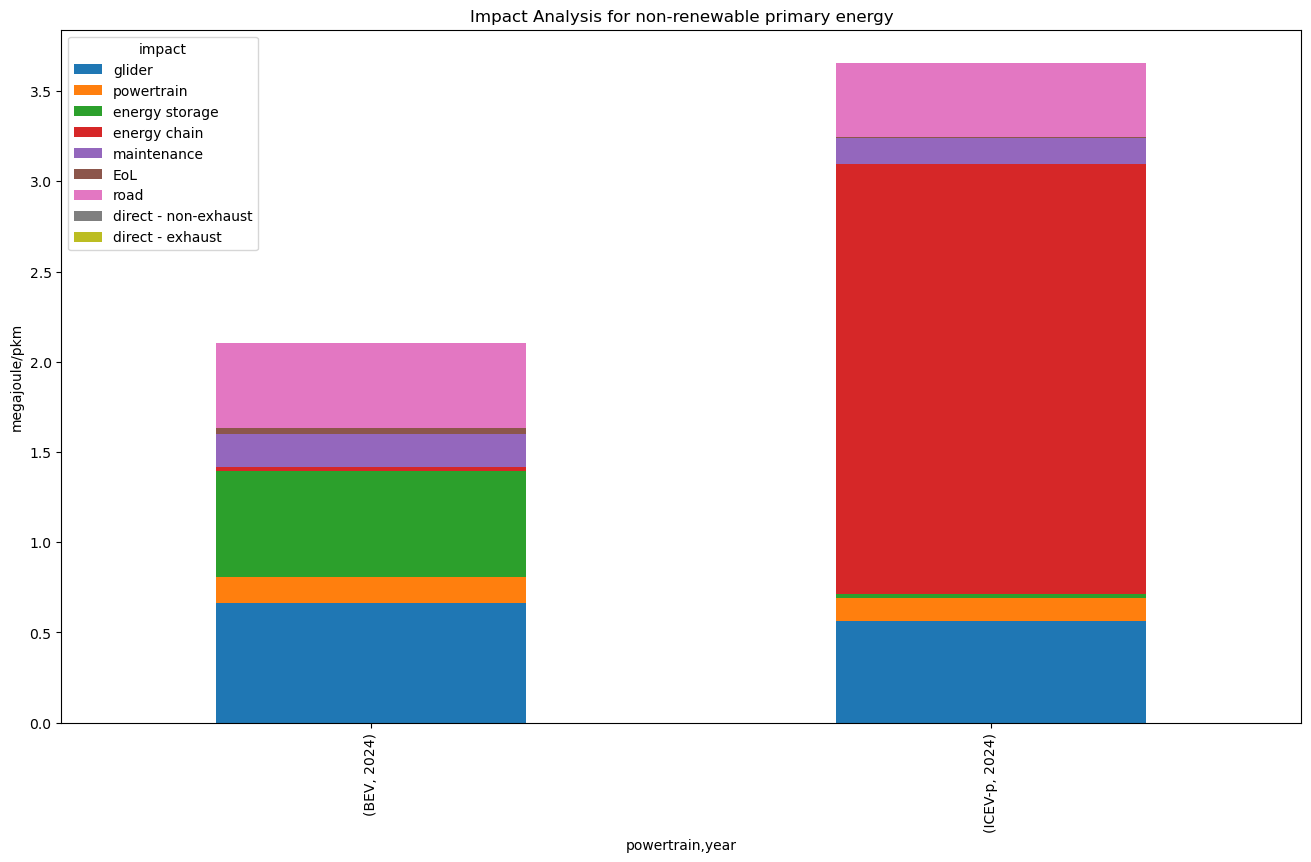

In [59]:
# results.sel(impact_category='non-renewable primary energy', size ="Small" , value=0)\
#     .to_dataframe('impact')\
#     .unstack(level=2)['impact']\
#     .plot(kind='bar', stacked=True, figsize=(16, 9))
# plt.ylabel('kg CO2-eq./vkm')
# plt.show()

# Example: Select impact_category
selected_impact_category = 'non-renewable primary energy'

# Get the corresponding unit
unit = get_unit(selected_impact_category, impact_cat)

# Plotting the data
results.sel(impact_category=selected_impact_category, size="Small", value=0)\
    .to_dataframe('impact')\
    .unstack(level=2)['impact']\
    .plot(kind='bar', stacked=True, figsize=(16, 9))

# Set the y-label dynamically based on the unit
plt.ylabel(f'{unit}/pkm')  # Use the dynamically selected unit
plt.title(f'Impact Analysis for {selected_impact_category}')
plt.show()

Midpoint results

In [55]:
# Extract all impact categories
all_impact_categories = list(ic.impact_categories.keys())

In [56]:
output = results.sel(impact_category=all_impact_categories,
                #      ['climate change', 'particulate matter formation', 
                #                       'photochemical oxidant formation', 'terrestrial acidification'], 
                                      size='Small', powertrain=['BEV', 'ICEV-p'], value=0)\
        .to_dataframe('impact')
# output_dict = dict(zip(['Direct emission (exhaust)', 'Direct emission (non-exhaust)', 'Energy chain', 
#                       'Maintenance', 'Chassis', 'End-of-Life', 'Powertrain', 
#                       'Energy storage', 'Road'], output.impact))

Endpoint results

In [57]:
# output = results.sel(impact_category=['Ecosystems', 'Human health', 'Resources'], 
#                      size='Small', 
#                      powertrain=['BEV', 'ICEV-p'], 
#                      value=0)\
#         .to_dataframe('impact')

In [58]:
lca_data = pd.DataFrame(output)
lca_data

size  \
impact_category              powertrain year impact                        
GWP100a                      BEV        2024 glider                Small   
                                             powertrain            Small   
                                             energy storage        Small   
                                             energy chain          Small   
                                             maintenance           Small   
...                                                                  ...   
non-renewable primary energy ICEV-p     2024 maintenance           Small   
                                             EoL                   Small   
                                             road                  Small   
                                             direct - non-exhaust  Small   
                                             direct - exhaust      Small   

                                                                   value  \
impact_category              powertrain year impact                        
GWP100a                      BEV        2024 glider                    0   
                                             powertrain                0   
                                             energy storage            0   
                                             energy chain              0   
                                             maintenance               0   
...                                                                  ...   
non-renewable primary energy ICEV-p     2024 maintenance               0   
                                             EoL                       0   
                                             road                      0   
                                             direct - non-exhaust      0   
                                             direct - exhaust          0   

                                                                        impact  
impact_category              powertrain year impact                             
GWP100a                      BEV        2024 glider                8842.585823  
                                             powertrain            2027.253965  
                                             energy storage        5907.628762  
                                             energy chain             0.002281  
                                             maintenance              0.009074  
...                                                                        ...  
non-renewable primary energy ICEV-p     2024 maintenance              0.146095  
                                             EoL                    935.601769  
                                             road                     0.408980  
                                             direct - non-exhaust     0.000000  
                                             direct - exhaust         0.000000  

[414 rows x 3 columns]

In [62]:
# Rename the MultiIndex level
lca_data = lca_data.rename_axis(index={'impact': 'vehicle_stage'})
# OR Rename the DataFrame column
lca_data = lca_data.rename(columns={'impact': 'impact_value'})


In [64]:
# Reset the MultiIndex to convert it to columns
lca_data_reset = lca_data.reset_index()

# Merge based on the 'key'
merged_df = lca_data_reset.merge(key_unit_df, on='impact_category', how='left')

# Display the result
print(merged_df)

                  impact_category powertrain  year         vehicle_stage  \
0                         GWP100a        BEV  2024                glider   
1                         GWP100a        BEV  2024            powertrain   
2                         GWP100a        BEV  2024        energy storage   
3                         GWP100a        BEV  2024          energy chain   
4                         GWP100a        BEV  2024           maintenance   
..                            ...        ...   ...                   ...   
409  non-renewable primary energy     ICEV-p  2024           maintenance   
410  non-renewable primary energy     ICEV-p  2024                   EoL   
411  non-renewable primary energy     ICEV-p  2024                  road   
412  non-renewable primary energy     ICEV-p  2024  direct - non-exhaust   
413  non-renewable primary energy     ICEV-p  2024      direct - exhaust   

      size  value  impact_value        unit  
0    Small      0   8842.585823  kg CO2-E

In [69]:
merged_df.to_csv("lca_data.csv", index=False)

In [83]:
# Sum the values in the 'impact' column
total_impact_sum = lca_data_reset['impact_value'].sum()

print(f'Total Impact Sum: {total_impact_sum}')

Total Impact Sum: 594686.5215779205


In [ ]:
output = results.sel(powertrain = 'BEV', impact_category='climate change', size='Small', value=0)\
        .to_dataframe('impact')

In [ ]:
output